# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


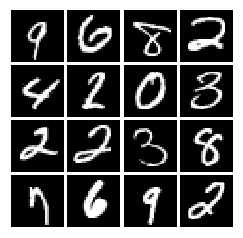

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])#picks exapmles and displays from mnist,if shuffle=True ,picks randomly

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x,0.0)+alpha*tf.minimum(x,0.0)
       

Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    shape=np.array([batch_size,dim]) 
    return tf.random_uniform(shape,minval=-1,maxval=1)


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x1=tf.layers.dense(inputs=x,units=256,activation=leaky_relu,use_bias=True)
        x2=tf.layers.dense(inputs=x1,units=256,activation=leaky_relu,use_bias=True)
        logits=tf.layers.dense(inputs=x2,units=1,activation=None,use_bias=True)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        x1=tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu,use_bias=True)
        x2=tf.layers.dense(inputs=x1,units=1024,activation=tf.nn.relu,use_bias=True)
        img=tf.layers.dense(inputs=x2,units=784,activation=tf.nn.tanh,use_bias=True)
        
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    g=tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake))
    d1=tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real))
    d2=tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_fake))
    d=d1+d2
    D_loss=tf.reduce_mean(d)
    G_loss=tf.reduce_mean(g)
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5,beta2=0.999):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1,beta2=beta2)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1,beta2=beta2)
    
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

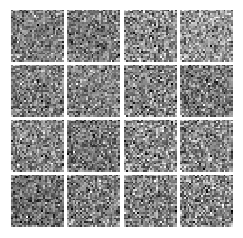


Iter: 0, D: 1.413, G:0.6959
Iter: 50, D: 0.2117, G:2.039
Iter: 100, D: 1.29, G:5.694
Iter: 150, D: 0.975, G:1.061
Iter: 200, D: 2.067, G:0.6863


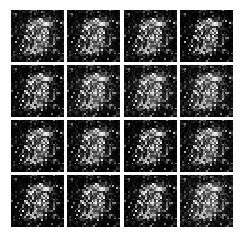


Iter: 250, D: 1.052, G:1.305
Iter: 300, D: 0.9802, G:1.207
Iter: 350, D: 1.283, G:1.34
Iter: 400, D: 1.203, G:1.326
Iter: 450, D: 1.268, G:1.241


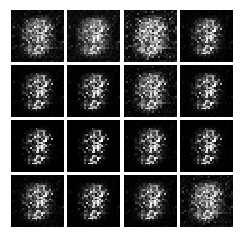


Iter: 500, D: 1.371, G:0.8828
Iter: 550, D: 1.665, G:0.7002
Iter: 600, D: 1.168, G:0.9494
Iter: 650, D: 0.9105, G:1.571
Iter: 700, D: 1.093, G:1.187


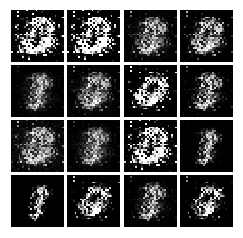


Iter: 750, D: 1.388, G:1.096
Iter: 800, D: 1.307, G:0.8093
Iter: 850, D: 1.234, G:1.081
Iter: 900, D: 1.168, G:1.204
Iter: 950, D: 1.187, G:1.215


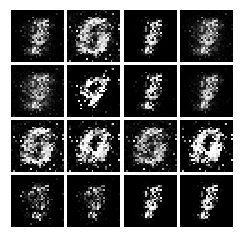


Iter: 1000, D: 1.456, G:0.857
Iter: 1050, D: 1.176, G:1.117
Iter: 1100, D: 1.225, G:0.9819
Iter: 1150, D: 1.303, G:0.8856
Iter: 1200, D: 1.147, G:1.744


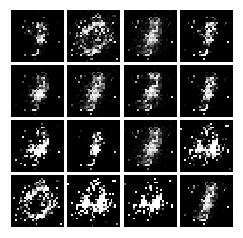


Iter: 1250, D: 1.146, G:1.06
Iter: 1300, D: 1.315, G:0.9381
Iter: 1350, D: 1.26, G:1.974
Iter: 1400, D: 1.514, G:0.6689
Iter: 1450, D: 1.31, G:0.8666


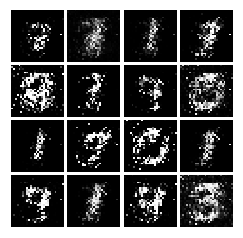


Iter: 1500, D: 1.346, G:1.509
Iter: 1550, D: 1.348, G:0.9186
Iter: 1600, D: 1.286, G:0.9157
Iter: 1650, D: 1.216, G:0.8936
Iter: 1700, D: 1.131, G:1.034


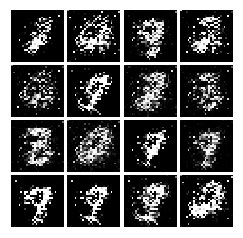


Iter: 1750, D: 1.162, G:1.193
Iter: 1800, D: 1.193, G:1.072
Iter: 1850, D: 1.6, G:1.202
Iter: 1900, D: 1.512, G:1.178
Iter: 1950, D: 1.304, G:0.8674


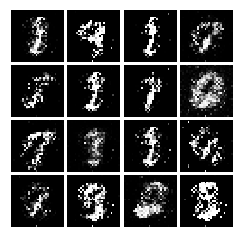


Iter: 2000, D: 1.31, G:0.7432
Iter: 2050, D: 1.368, G:0.7224
Iter: 2100, D: 1.296, G:0.8074
Iter: 2150, D: 1.458, G:0.7098
Iter: 2200, D: 1.272, G:0.9962


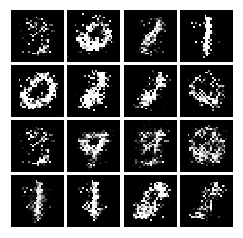


Iter: 2250, D: 1.465, G:0.8221
Iter: 2300, D: 1.348, G:0.8261
Iter: 2350, D: 1.387, G:0.9005
Iter: 2400, D: 1.22, G:1.111
Iter: 2450, D: 1.383, G:0.7715


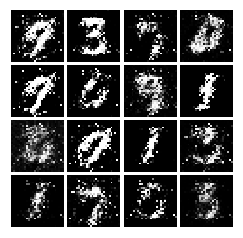


Iter: 2500, D: 1.342, G:0.8383
Iter: 2550, D: 1.26, G:0.8645
Iter: 2600, D: 1.252, G:0.8835
Iter: 2650, D: 1.278, G:0.8247
Iter: 2700, D: 1.339, G:0.9518


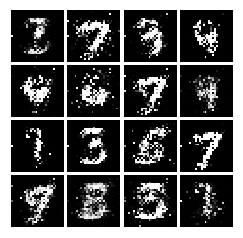


Iter: 2750, D: 1.242, G:0.5461
Iter: 2800, D: 1.342, G:1.087
Iter: 2850, D: 1.269, G:0.9058
Iter: 2900, D: 1.21, G:0.9236
Iter: 2950, D: 1.289, G:0.7621


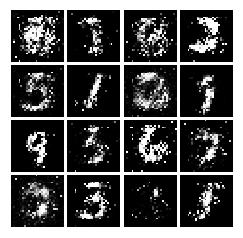


Iter: 3000, D: 1.323, G:0.8485
Iter: 3050, D: 1.391, G:0.7477
Iter: 3100, D: 1.363, G:0.8217
Iter: 3150, D: 1.395, G:0.8783
Iter: 3200, D: 1.359, G:0.7401


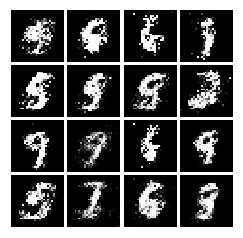


Iter: 3250, D: 1.343, G:0.7893
Iter: 3300, D: 1.349, G:0.848
Iter: 3350, D: 1.319, G:0.7629
Iter: 3400, D: 1.433, G:0.7233
Iter: 3450, D: 1.369, G:0.7891


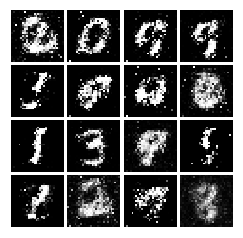


Iter: 3500, D: 1.3, G:0.8875
Iter: 3550, D: 1.382, G:0.7808
Iter: 3600, D: 1.394, G:0.7395
Iter: 3650, D: 1.343, G:0.7127
Iter: 3700, D: 1.385, G:0.7576


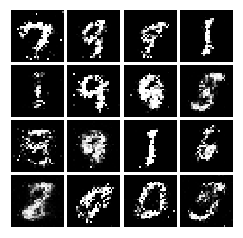


Iter: 3750, D: 1.305, G:0.8139
Iter: 3800, D: 1.359, G:0.7557
Iter: 3850, D: 1.371, G:0.6824
Iter: 3900, D: 1.268, G:0.5762
Iter: 3950, D: 1.287, G:0.8002


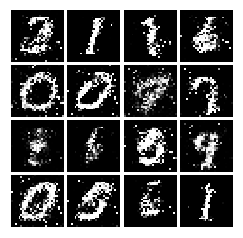


Iter: 4000, D: 1.36, G:0.6974
Iter: 4050, D: 1.374, G:0.8011
Iter: 4100, D: 1.39, G:0.748
Iter: 4150, D: 1.34, G:0.7884
Iter: 4200, D: 1.4, G:0.7864


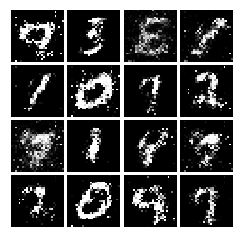


Iter: 4250, D: 1.371, G:0.7851
Final images


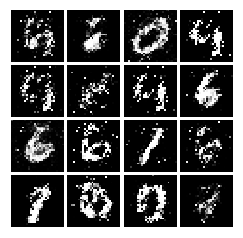

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [17]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    G_loss = 0.5*tf.reduce_mean(tf.square(tf.subtract(score_fake,1)))
    D_loss = 0.5*(tf.reduce_mean(tf.square(tf.subtract(score_real,1)))+tf.reduce_mean(tf.square(score_fake)))
    
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [18]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [19]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

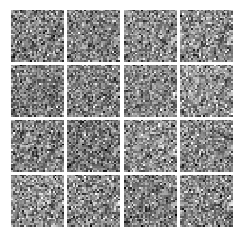


Iter: 0, D: 0.4575, G:0.3813
Iter: 50, D: 0.01075, G:0.7311
Iter: 100, D: 0.05575, G:0.746
Iter: 150, D: 0.2057, G:0.3798
Iter: 200, D: 0.08621, G:0.3777


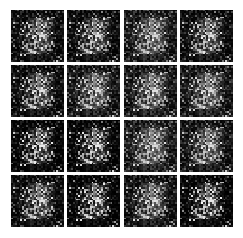


Iter: 250, D: 0.07095, G:0.7163
Iter: 300, D: 0.1114, G:0.2335
Iter: 350, D: 0.07824, G:0.6072
Iter: 400, D: 0.3525, G:0.06846
Iter: 450, D: 0.3359, G:0.1338


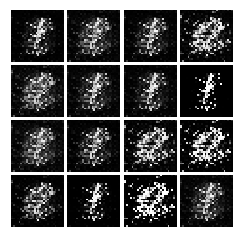


Iter: 500, D: 0.08736, G:0.4463
Iter: 550, D: 0.06568, G:0.4969
Iter: 600, D: 0.1446, G:0.5361
Iter: 650, D: 0.1317, G:0.326
Iter: 700, D: 0.1772, G:0.1596


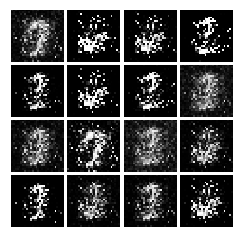


Iter: 750, D: 0.1667, G:0.3283
Iter: 800, D: 0.1465, G:0.3294
Iter: 850, D: 0.2227, G:0.3015
Iter: 900, D: 0.1224, G:0.4874
Iter: 950, D: 0.1495, G:0.3224


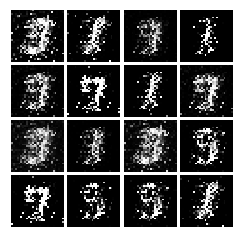


Iter: 1000, D: 0.1584, G:0.3174
Iter: 1050, D: 0.4932, G:0.04852
Iter: 1100, D: 0.1369, G:0.3385
Iter: 1150, D: 0.1129, G:0.4579
Iter: 1200, D: 0.1318, G:0.3141


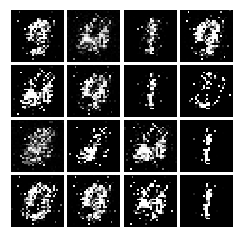


Iter: 1250, D: 0.155, G:0.468
Iter: 1300, D: 0.1466, G:0.2957
Iter: 1350, D: 0.3498, G:0.1752
Iter: 1400, D: 0.2095, G:0.2626
Iter: 1450, D: 0.1646, G:0.2397


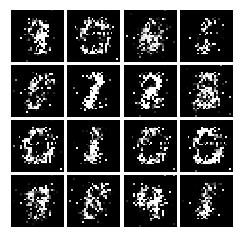


Iter: 1500, D: 0.1693, G:0.2465
Iter: 1550, D: 0.1953, G:0.2422
Iter: 1600, D: 0.1889, G:0.29
Iter: 1650, D: 0.2054, G:0.3639
Iter: 1700, D: 0.1809, G:0.2296


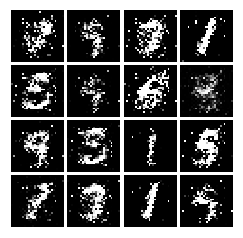


Iter: 1750, D: 0.1761, G:0.2697
Iter: 1800, D: 0.2515, G:0.2077
Iter: 1850, D: 0.1726, G:0.2385
Iter: 1900, D: 0.2117, G:0.7548
Iter: 1950, D: 0.1918, G:0.2112


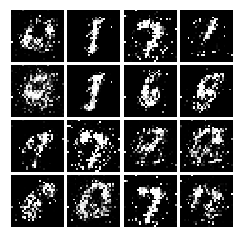


Iter: 2000, D: 0.2151, G:0.2349
Iter: 2050, D: 0.1919, G:0.2278
Iter: 2100, D: 0.2044, G:0.2577
Iter: 2150, D: 0.206, G:0.225
Iter: 2200, D: 0.2027, G:0.2201


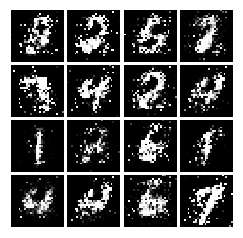


Iter: 2250, D: 0.2204, G:0.2253
Iter: 2300, D: 0.2082, G:0.182
Iter: 2350, D: 0.2066, G:0.198
Iter: 2400, D: 0.2153, G:0.1909
Iter: 2450, D: 0.2042, G:0.2125


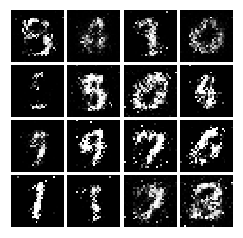


Iter: 2500, D: 0.2443, G:0.2429
Iter: 2550, D: 0.2185, G:0.189
Iter: 2600, D: 0.2274, G:0.1947
Iter: 2650, D: 0.2123, G:0.1723
Iter: 2700, D: 0.2407, G:0.1638


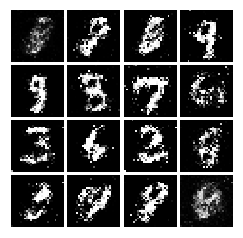


Iter: 2750, D: 0.2288, G:0.1606
Iter: 2800, D: 0.2034, G:0.1853
Iter: 2850, D: 0.2144, G:0.1941
Iter: 2900, D: 0.2173, G:0.2029
Iter: 2950, D: 0.2153, G:0.2255


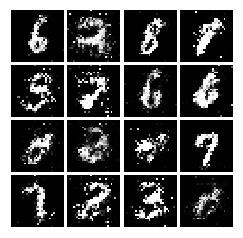


Iter: 3000, D: 0.2114, G:0.1704
Iter: 3050, D: 0.2128, G:0.1991
Iter: 3100, D: 0.2076, G:0.1919
Iter: 3150, D: 0.217, G:0.2063
Iter: 3200, D: 0.2009, G:0.207


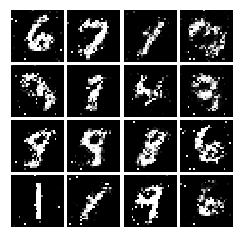


Iter: 3250, D: 0.2497, G:0.2057
Iter: 3300, D: 0.2187, G:0.185
Iter: 3350, D: 0.2235, G:0.2371
Iter: 3400, D: 0.1986, G:0.214
Iter: 3450, D: 0.2205, G:0.2053


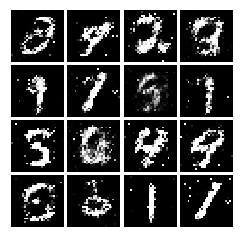


Iter: 3500, D: 0.2229, G:0.1952
Iter: 3550, D: 0.2397, G:0.1594
Iter: 3600, D: 0.2078, G:0.1848
Iter: 3650, D: 0.2047, G:0.1832
Iter: 3700, D: 0.234, G:0.1753


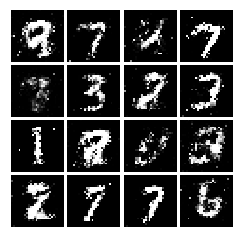


Iter: 3750, D: 0.2206, G:0.1701
Iter: 3800, D: 0.225, G:0.1883
Iter: 3850, D: 0.2248, G:0.1784
Iter: 3900, D: 0.2128, G:0.1651
Iter: 3950, D: 0.2212, G:0.1574


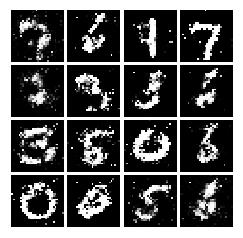


Iter: 4000, D: 0.205, G:0.1582
Iter: 4050, D: 0.2366, G:0.176
Iter: 4100, D: 0.2185, G:0.1616
Iter: 4150, D: 0.2196, G:0.1764
Iter: 4200, D: 0.23, G:0.183


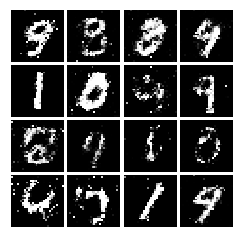


Iter: 4250, D: 0.2386, G:0.1743
Final images


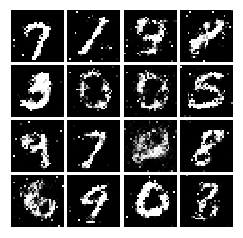

In [19]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [20]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        input_layer = tf.reshape(x, [-1, 28, 28, 1])

        conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        
        [N, H, Wi, C] = pool2.get_shape().as_list()
        
        pool2_flat = tf.reshape(pool2, [-1, H*Wi*C])#pool2 is of shape(7,7,64)
        dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=leaky_relu)
        logits = tf.layers.dense(inputs=dense, units=1)
        #print(logits.get_shape())
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [21]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        full_1=tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu)
        batch_norm_1=tf.layers.batch_normalization(full_1)
        #print(batch_norm_1.get_shape())
        full_2=tf.layers.dense(inputs=batch_norm_1,units=7*7*128,activation=tf.nn.relu)
        batch_norm_2=tf.layers.batch_normalization(full_2)
        
        #input_layer = tf.reshape(batch_norm_2, [-1, 28, 28, 8])
        input_layer = tf.reshape(batch_norm_2, [-1, 7, 7, 128])
        #print(input_layer.get_shape())
        #input_layer = tf.image.resize_images(batch_norm_2, [28, 28])
        
        [N, H, Wi, C] = input_layer.get_shape().as_list()
        #gen_W3 = tf.Variable(tf.random_normal([4,4,64,128], stddev=0.01), name='gen_W3')
        #output_shape=[N,14,14,64]
        #strides=[1,2,2,1]
        #bias = tf.Variable(tf.random_normal([64], stddev=0.0), dtype=tf.float32)
        #conv1 = tf.nn.conv2d_transpose(value=input_layer,filter=gen_W3,output_shape=output_shape,strides=strides,padding='SAME')
        #conv1_bias = tf.nn.bias_add(conv1, bias)
        #conv1=tf.nn.relu(conv1_bias)
        #batch_norm_3=tf.layers.batch_normalization(conv1,axis=3)
        #print(batch_norm_3.get_shape())
        
        #[N, H, Wi, C] = batch_norm_3.get_shape().as_list()
        #filter=tf.constant(0.1,shape=[4,4,1,64])
        #gen_W4 = tf.Variable(tf.random_normal([4,4,1,64], stddev=0.01), name='gen_W4')
        #output_shape=[N,28,28,1]
        #strides=[1,2,2,1]
        #img = tf.nn.conv2d_transpose(value=batch_norm_3,filter=gen_W4,output_shape=output_shape,strides=strides,padding='SAME')
        #bias = tf.Variable(tf.random_normal([1], stddev=0.0), dtype=tf.float32)
        #img_bias = tf.nn.bias_add(img, bias)
        #img= tf.nn.tanh(img_bias)
        
        deconv1 = tf.layers.conv2d_transpose(input_layer, filters=64, kernel_size=4, strides=2, padding="same", activation=tf.nn.relu)
        bnorm = tf.layers.batch_normalization(deconv1, axis=3)
        img = tf.layers.conv2d_transpose(bnorm, filters=1, kernel_size=4, strides=2, padding="same", activation=tf.nn.tanh)
        print(img.get_shape())
        img=tf.reshape(img,[-1,784])
        print(img.get_shape())
        
        return img
test_generator(6595521)

(1, 28, 28, 1)
(1, 784)
Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [22]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    print(G_sample.get_shape())
    logits_fake = discriminator(G_sample)
    
# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

(128, 28, 28, 1)
(128, 784)
(128, 784)


### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

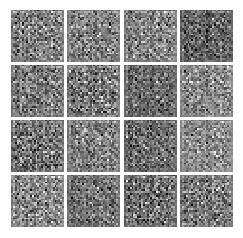


Iter: 0, D: 1.424, G:0.6582
Iter: 50, D: 0.7194, G:2.096
Iter: 100, D: 0.7046, G:2.593
Iter: 150, D: 0.1612, G:4.472
Iter: 200, D: 1.024, G:2.981


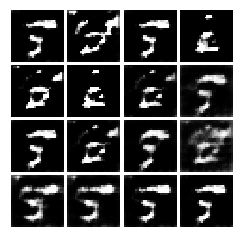


Iter: 250, D: 0.6347, G:1.738
Iter: 300, D: 0.6465, G:2.123
Iter: 350, D: 0.6537, G:2.697
Iter: 400, D: 0.3512, G:3.266
Iter: 450, D: 0.5439, G:3.672


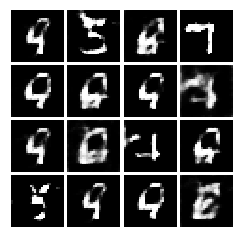


Iter: 500, D: 0.5426, G:2.417
Iter: 550, D: 0.4259, G:3.104
Iter: 600, D: 0.507, G:2.672
Iter: 650, D: 0.6629, G:1.808
Iter: 700, D: 0.5045, G:2.348


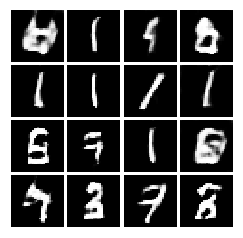


Iter: 750, D: 1.018, G:0.6799
Iter: 800, D: 1.03, G:3.001
Iter: 850, D: 0.4945, G:1.968
Iter: 900, D: 0.6729, G:1.962
Iter: 950, D: 0.7623, G:2.404


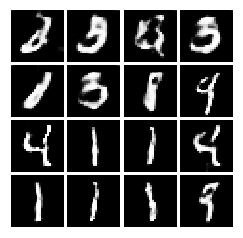


Iter: 1000, D: 0.7254, G:1.81
Iter: 1050, D: 0.6743, G:1.471
Iter: 1100, D: 0.7435, G:2.139
Iter: 1150, D: 0.7789, G:1.998
Iter: 1200, D: 1.133, G:1.248


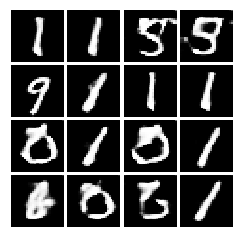


Iter: 1250, D: 0.6605, G:1.974
Iter: 1300, D: 0.7388, G:1.946
Iter: 1350, D: 0.7099, G:1.947
Iter: 1400, D: 0.7723, G:1.3
Iter: 1450, D: 0.7473, G:1.631


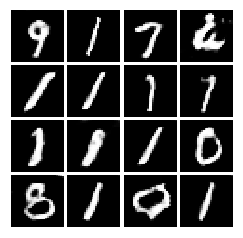


Iter: 1500, D: 0.8636, G:1.704
Iter: 1550, D: 1.071, G:2.765
Iter: 1600, D: 0.9696, G:1.243
Iter: 1650, D: 0.9049, G:1.232
Iter: 1700, D: 0.8529, G:1.496


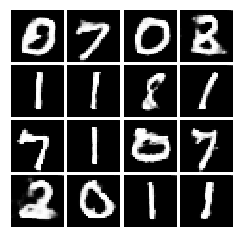


Iter: 1750, D: 0.7902, G:1.513
Iter: 1800, D: 0.8982, G:2.077
Iter: 1850, D: 0.8647, G:1.449
Iter: 1900, D: 0.8482, G:1.17
Iter: 1950, D: 0.9902, G:1.683


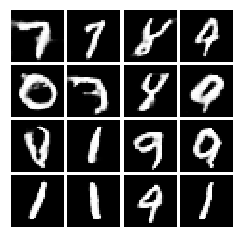


Iter: 2000, D: 0.9338, G:1.853
Iter: 2050, D: 0.8617, G:1.33
Iter: 2100, D: 0.8426, G:1.604
Iter: 2150, D: 1.029, G:2.026
Iter: 2200, D: 0.742, G:1.557


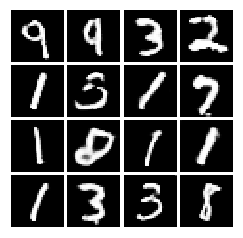


Iter: 2250, D: 0.9412, G:1.984
Iter: 2300, D: 0.9872, G:1.351
Iter: 2350, D: 0.9647, G:1.572
Iter: 2400, D: 0.9546, G:1.584
Iter: 2450, D: 0.8313, G:1.149


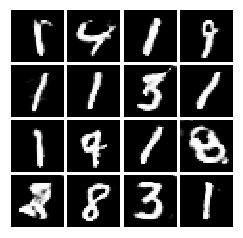


Iter: 2500, D: 0.8104, G:1.467
Iter: 2550, D: 0.9701, G:0.9986
Iter: 2600, D: 1.044, G:2.199
Iter: 2650, D: 0.9715, G:1.734
Iter: 2700, D: 0.9241, G:1.324


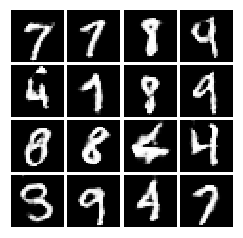


Iter: 2750, D: 0.8543, G:1.538
Iter: 2800, D: 0.7775, G:1.441
Iter: 2850, D: 1.213, G:0.9554
Iter: 2900, D: 0.9367, G:1.061
Iter: 2950, D: 0.8827, G:1.302


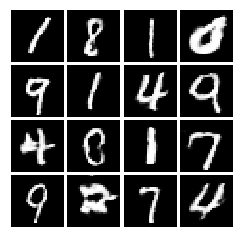


Iter: 3000, D: 0.9501, G:1.692
Iter: 3050, D: 0.8025, G:1.471
Iter: 3100, D: 0.9743, G:1.252
Iter: 3150, D: 0.7933, G:1.586
Iter: 3200, D: 0.9139, G:1.474


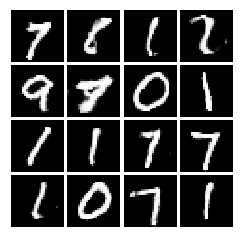


Iter: 3250, D: 0.9533, G:1.275
Iter: 3300, D: 0.7364, G:1.828
Iter: 3350, D: 0.7433, G:1.954
Iter: 3400, D: 0.7769, G:1.719
Iter: 3450, D: 0.7571, G:1.552


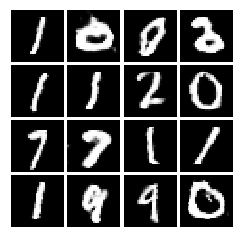


Iter: 3500, D: 0.9465, G:1.582
Iter: 3550, D: 0.8745, G:1.456
Iter: 3600, D: 0.9928, G:1.942
Iter: 3650, D: 0.8001, G:1.471
Iter: 3700, D: 0.7226, G:1.189


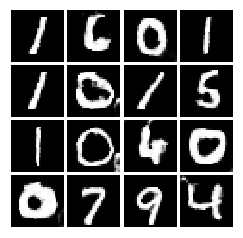


Iter: 3750, D: 0.7461, G:1.398
Iter: 3800, D: 0.7702, G:1.59
Iter: 3850, D: 0.801, G:1.369
Iter: 3900, D: 0.8182, G:1.725
Iter: 3950, D: 0.7581, G:1.063


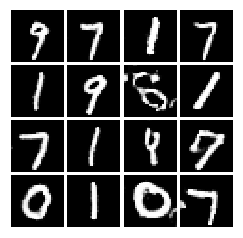


Iter: 4000, D: 0.7855, G:2.015
Iter: 4050, D: 0.5987, G:1.829
Iter: 4100, D: 0.7039, G:2.006
Iter: 4150, D: 0.7739, G:1.483
Iter: 4200, D: 0.8543, G:1.446


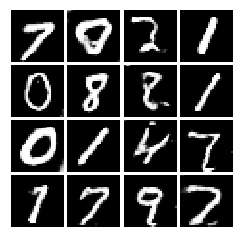


Iter: 4250, D: 0.7415, G:1.977
Iter: 4300, D: 0.7814, G:1.251
Iter: 4350, D: 1.001, G:2.212
Iter: 4400, D: 0.6759, G:1.528
Iter: 4450, D: 0.6692, G:1.98


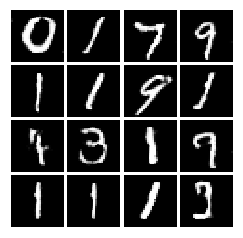


Iter: 4500, D: 0.8311, G:2.992
Iter: 4550, D: 0.7807, G:1.447
Iter: 4600, D: 0.7418, G:1.29
Iter: 4650, D: 0.6821, G:2.092
Iter: 4700, D: 0.7508, G:1.606


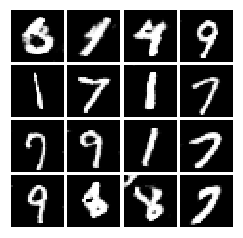


Iter: 4750, D: 0.6363, G:1.308
Iter: 4800, D: 0.6939, G:1.495
Iter: 4850, D: 0.6022, G:1.597
Iter: 4900, D: 0.7043, G:1.406
Iter: 4950, D: 0.7829, G:2.519


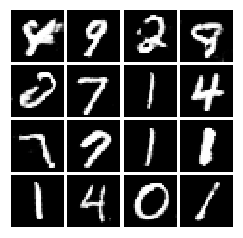


Iter: 5000, D: 0.7519, G:1.73
Iter: 5050, D: 0.7506, G:1.558
Iter: 5100, D: 1.008, G:2.786
Iter: 5150, D: 0.651, G:2.077
Iter: 5200, D: 0.6357, G:1.692


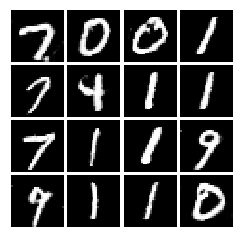


Iter: 5250, D: 0.6809, G:1.71
Iter: 5300, D: 0.9926, G:1.213
Iter: 5350, D: 0.6946, G:1.599
Iter: 5400, D: 0.7925, G:2.249
Iter: 5450, D: 0.6573, G:1.939


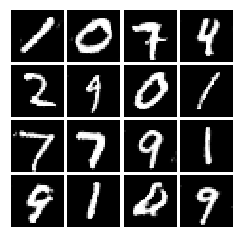


Iter: 5500, D: 0.7172, G:1.975
Iter: 5550, D: 0.6187, G:2.066
Iter: 5600, D: 0.6469, G:1.628
Iter: 5650, D: 0.6757, G:1.603
Iter: 5700, D: 0.6439, G:2.159


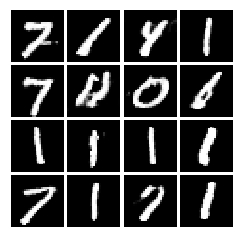


Iter: 5750, D: 0.5455, G:2.561
Iter: 5800, D: 0.5707, G:2.262
Iter: 5850, D: 0.7555, G:1.666
Iter: 5900, D: 0.6666, G:1.333
Iter: 5950, D: 0.6597, G:1.677


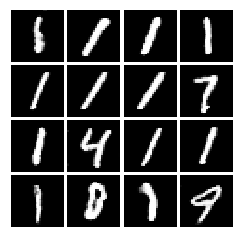


Iter: 6000, D: 0.6695, G:1.461
Iter: 6050, D: 0.6798, G:1.921
Iter: 6100, D: 0.6301, G:2.023
Iter: 6150, D: 0.6755, G:1.977
Iter: 6200, D: 0.439, G:2.125


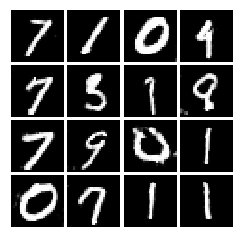


Iter: 6250, D: 0.5281, G:1.963
Iter: 6300, D: 0.553, G:1.948
Iter: 6350, D: 0.5682, G:1.786
Iter: 6400, D: 0.5642, G:2.138
Iter: 6450, D: 0.6177, G:1.95


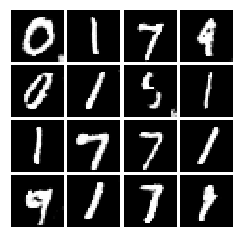


Iter: 6500, D: 0.6856, G:1.335
Iter: 6550, D: 0.5124, G:1.979
Iter: 6600, D: 0.6424, G:1.571
Iter: 6650, D: 0.6458, G:1.592
Iter: 6700, D: 0.6346, G:2.369


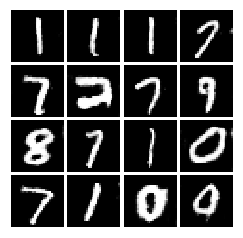


Iter: 6750, D: 0.5629, G:1.988
Iter: 6800, D: 0.5913, G:1.954
Iter: 6850, D: 0.5666, G:1.984
Iter: 6900, D: 0.5548, G:1.762
Iter: 6950, D: 0.4913, G:2.442


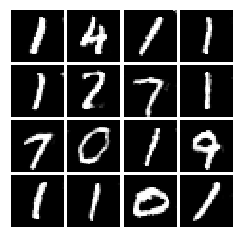


Iter: 7000, D: 0.5153, G:2.225
Iter: 7050, D: 0.4916, G:1.924
Iter: 7100, D: 0.4345, G:2.285
Iter: 7150, D: 0.58, G:2.136
Iter: 7200, D: 0.5643, G:1.955


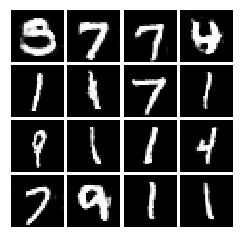


Iter: 7250, D: 0.4844, G:1.929
Iter: 7300, D: 0.5675, G:2.247
Iter: 7350, D: 0.5733, G:2.16
Iter: 7400, D: 0.5175, G:2.499
Iter: 7450, D: 0.5357, G:1.674


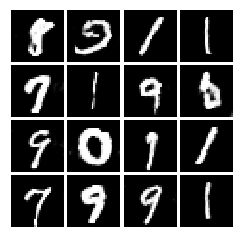


Iter: 7500, D: 0.541, G:1.935
Iter: 7550, D: 0.5218, G:2.725
Iter: 7600, D: 0.6066, G:2.012
Iter: 7650, D: 0.5708, G:2.768
Iter: 7700, D: 0.4323, G:1.996


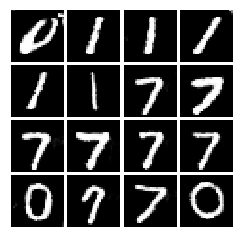


Iter: 7750, D: 0.7989, G:2.047
Iter: 7800, D: 0.6401, G:1.847
Iter: 7850, D: 0.5769, G:2.551
Iter: 7900, D: 0.4625, G:2.017
Iter: 7950, D: 0.4888, G:2.375


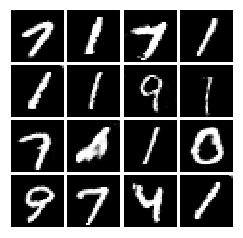


Iter: 8000, D: 0.5083, G:2.769
Iter: 8050, D: 0.529, G:2.208
Iter: 8100, D: 0.5186, G:2.333
Iter: 8150, D: 0.6496, G:1.903
Iter: 8200, D: 0.483, G:2.615


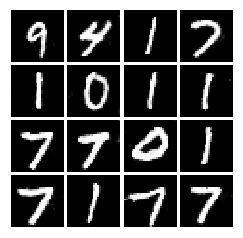


Iter: 8250, D: 0.4301, G:1.69
Iter: 8300, D: 0.6386, G:1.577
Iter: 8350, D: 0.4363, G:2.084
Iter: 8400, D: 0.8243, G:3.392
Iter: 8450, D: 0.6049, G:2.34


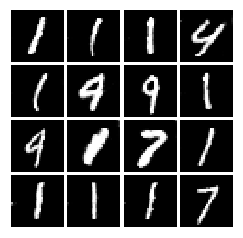


Iter: 8500, D: 0.5435, G:2.05
Iter: 8550, D: 0.4669, G:2.116
Iter: 8600, D: 0.5903, G:2.405
Iter: 8650, D: 0.4608, G:1.87
Iter: 8700, D: 0.5057, G:2.235


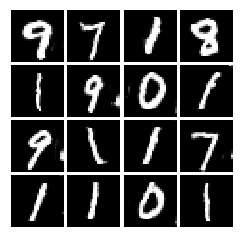


Iter: 8750, D: 0.4699, G:2.306
Iter: 8800, D: 0.3858, G:2.424
Iter: 8850, D: 0.4127, G:2.431
Iter: 8900, D: 0.4232, G:2.555
Iter: 8950, D: 0.4584, G:1.965


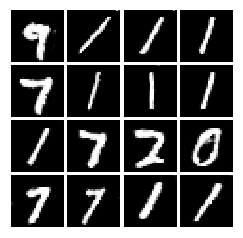


Iter: 9000, D: 0.5001, G:1.917
Iter: 9050, D: 0.4578, G:1.667
Iter: 9100, D: 0.5, G:2.103
Iter: 9150, D: 0.4988, G:2.327
Iter: 9200, D: 0.5121, G:2.176


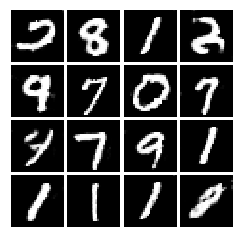


Iter: 9250, D: 0.4026, G:2.326
Iter: 9300, D: 0.6205, G:2.255
Iter: 9350, D: 0.6077, G:1.896
Iter: 9400, D: 0.4902, G:2.076
Iter: 9450, D: 0.4774, G:2.338


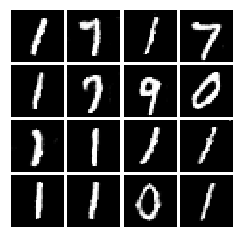


Iter: 9500, D: 0.3966, G:2.601
Iter: 9550, D: 0.4942, G:2.897
Iter: 9600, D: 0.4573, G:2.613
Iter: 9650, D: 0.4471, G:2.165
Iter: 9700, D: 0.5117, G:2.86


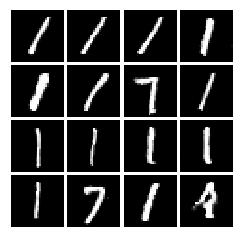


Iter: 9750, D: 0.5576, G:1.897
Iter: 9800, D: 0.4577, G:3.017
Iter: 9850, D: 0.4252, G:2.082
Iter: 9900, D: 0.4625, G:2.424
Iter: 9950, D: 0.3658, G:2.238


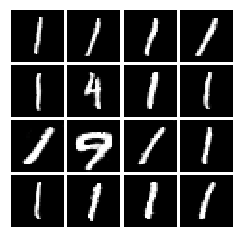


Iter: 10000, D: 0.4906, G:1.945
Iter: 10050, D: 0.437, G:2.177
Iter: 10100, D: 0.5117, G:2.971
Iter: 10150, D: 0.3208, G:2.554
Iter: 10200, D: 0.4133, G:2.573


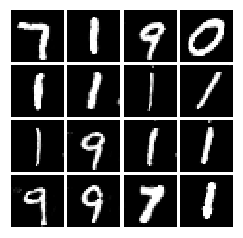


Iter: 10250, D: 0.3926, G:2.344
Iter: 10300, D: 0.4259, G:2.811
Iter: 10350, D: 0.4065, G:2.219
Iter: 10400, D: 0.2579, G:2.972
Iter: 10450, D: 0.3278, G:2.507


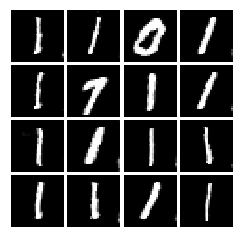


Iter: 10500, D: 0.3675, G:2.553
Iter: 10550, D: 0.4913, G:2.076
Iter: 10600, D: 0.513, G:2.321
Iter: 10650, D: 0.3613, G:2.223
Iter: 10700, D: 0.4012, G:2.095


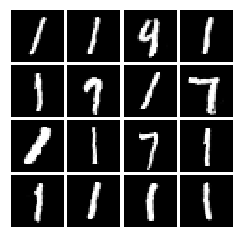


Iter: 10750, D: 0.3973, G:2.399
Iter: 10800, D: 0.3229, G:2.945
Iter: 10850, D: 0.4156, G:2.569
Iter: 10900, D: 0.4151, G:2.452
Iter: 10950, D: 0.4491, G:2.478


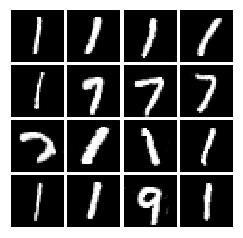


Iter: 11000, D: 0.33, G:2.689
Iter: 11050, D: 0.4896, G:2.181
Iter: 11100, D: 0.344, G:2.859
Iter: 11150, D: 0.3666, G:2.5
Iter: 11200, D: 0.3994, G:2.389


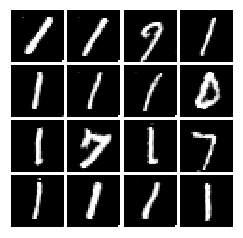


Iter: 11250, D: 0.3807, G:2.706
Iter: 11300, D: 0.4535, G:2.507
Iter: 11350, D: 0.4446, G:2.639
Iter: 11400, D: 0.3853, G:2.344
Iter: 11450, D: 0.5502, G:2.575


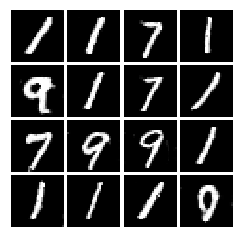


Iter: 11500, D: 0.3261, G:3.149
Iter: 11550, D: 0.4072, G:2.638
Iter: 11600, D: 0.3389, G:2.992
Iter: 11650, D: 0.4587, G:3.063
Iter: 11700, D: 0.3268, G:2.84


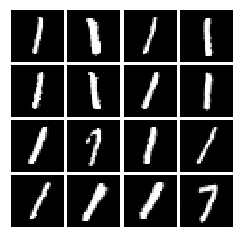


Iter: 11750, D: 0.2959, G:3.047
Iter: 11800, D: 0.4002, G:2.589
Iter: 11850, D: 0.3757, G:2.791
Iter: 11900, D: 0.4676, G:2.488
Iter: 11950, D: 0.4425, G:2.28


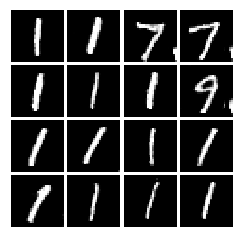


Iter: 12000, D: 0.4185, G:2.057
Iter: 12050, D: 0.3793, G:2.798
Iter: 12100, D: 0.4267, G:3.086
Iter: 12150, D: 0.4282, G:2.576
Iter: 12200, D: 0.2717, G:2.629


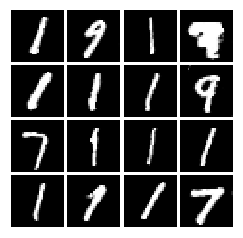


Iter: 12250, D: 0.3243, G:2.542
Iter: 12300, D: 0.2682, G:2.889
Iter: 12350, D: 0.3657, G:2.955
Iter: 12400, D: 0.4529, G:2.582
Iter: 12450, D: 0.4443, G:2.611


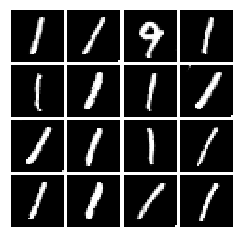


Iter: 12500, D: 0.3766, G:2.391
Iter: 12550, D: 0.4425, G:2.487
Iter: 12600, D: 0.3104, G:2.603
Iter: 12650, D: 0.366, G:3.338
Iter: 12700, D: 0.4447, G:2.808


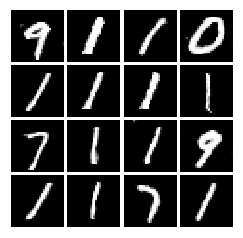


Iter: 12750, D: 0.3998, G:2.436
Iter: 12800, D: 0.4033, G:3.223
Iter: 12850, D: 0.343, G:2.419
Iter: 12900, D: 0.3412, G:2.687
Iter: 12950, D: 0.3643, G:2.419


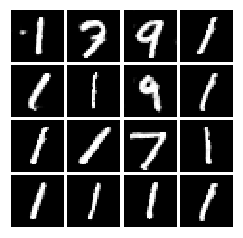


Iter: 13000, D: 0.2998, G:2.94
Iter: 13050, D: 0.3728, G:2.748
Iter: 13100, D: 0.396, G:3.253
Iter: 13150, D: 0.2479, G:3.196
Iter: 13200, D: 0.3265, G:3.35


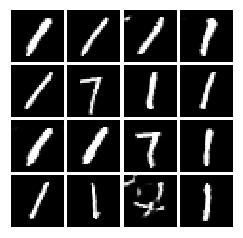


Iter: 13250, D: 0.4844, G:2.739
Iter: 13300, D: 0.275, G:3.03
Iter: 13350, D: 0.3494, G:2.286
Iter: 13400, D: 0.3167, G:3.228
Iter: 13450, D: 0.2737, G:2.849


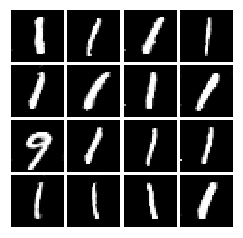


Iter: 13500, D: 0.3358, G:2.639
Iter: 13550, D: 0.3455, G:3.049
Iter: 13600, D: 0.3673, G:4.082
Iter: 13650, D: 0.4043, G:2.683
Iter: 13700, D: 0.2792, G:2.786


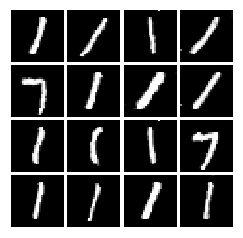


Iter: 13750, D: 0.3807, G:2.47
Iter: 13800, D: 0.3532, G:3.765
Iter: 13850, D: 0.221, G:3.421
Iter: 13900, D: 0.3732, G:3.382
Iter: 13950, D: 0.2344, G:3.006


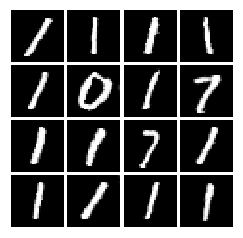


Iter: 14000, D: 0.292, G:2.698
Iter: 14050, D: 0.4489, G:2.391
Iter: 14100, D: 0.4185, G:3.243
Iter: 14150, D: 0.2415, G:3.106
Iter: 14200, D: 0.2993, G:2.773


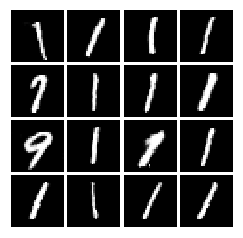


Iter: 14250, D: 0.2664, G:3.612
Iter: 14300, D: 0.2838, G:2.059
Iter: 14350, D: 0.305, G:3.193
Iter: 14400, D: 0.291, G:3.114
Iter: 14450, D: 0.2442, G:2.936


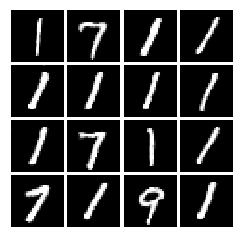


Iter: 14500, D: 0.2913, G:3.132
Iter: 14550, D: 0.1905, G:3.538
Iter: 14600, D: 0.2789, G:3.097
Iter: 14650, D: 0.3101, G:2.447
Iter: 14700, D: 0.2449, G:3.01


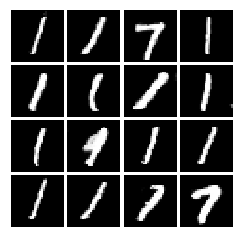


Iter: 14750, D: 0.2571, G:3.117
Iter: 14800, D: 0.239, G:3.083
Iter: 14850, D: 0.324, G:3.105
Iter: 14900, D: 0.2441, G:3.239
Iter: 14950, D: 0.2705, G:3.797


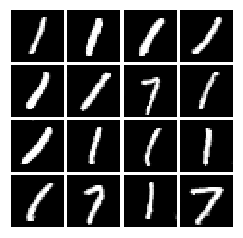


Iter: 15000, D: 0.278, G:3.612
Iter: 15050, D: 0.1891, G:3.612
Iter: 15100, D: 0.2544, G:3.514
Iter: 15150, D: 0.2915, G:3.433
Iter: 15200, D: 0.2564, G:2.9


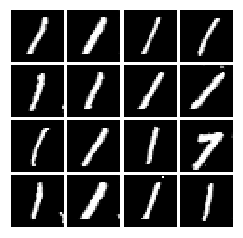


Iter: 15250, D: 0.3394, G:3.982
Iter: 15300, D: 0.3313, G:3.213
Iter: 15350, D: 0.3641, G:2.792
Iter: 15400, D: 0.229, G:2.939
Iter: 15450, D: 0.1747, G:3.871


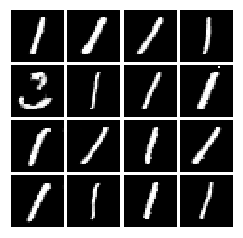


Iter: 15500, D: 0.2813, G:3.926
Iter: 15550, D: 0.187, G:4.205
Iter: 15600, D: 0.2621, G:3.462
Iter: 15650, D: 0.2378, G:4.091
Iter: 15700, D: 0.2684, G:3.977


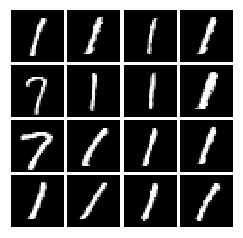


Iter: 15750, D: 0.2715, G:2.598
Iter: 15800, D: 0.2099, G:3.429
Iter: 15850, D: 0.1844, G:3.386
Iter: 15900, D: 0.1981, G:4.025
Iter: 15950, D: 0.1979, G:3.781


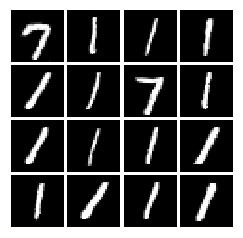


Iter: 16000, D: 0.2968, G:3.173
Iter: 16050, D: 0.2513, G:3.629
Iter: 16100, D: 0.2159, G:3.465
Iter: 16150, D: 0.2258, G:3.704
Iter: 16200, D: 0.2697, G:2.723


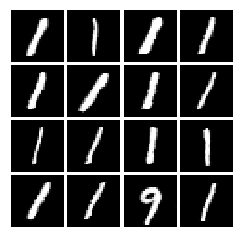


Iter: 16250, D: 0.2397, G:3.446
Iter: 16300, D: 0.1862, G:3.695
Iter: 16350, D: 0.3464, G:4.459
Iter: 16400, D: 0.2161, G:3.597
Iter: 16450, D: 0.1654, G:3.997


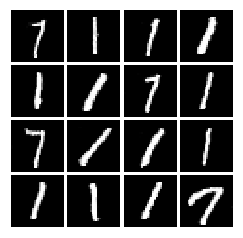


Iter: 16500, D: 0.2103, G:4.21
Iter: 16550, D: 0.1865, G:4.496
Iter: 16600, D: 0.2748, G:3.445
Iter: 16650, D: 0.2556, G:3.58
Iter: 16700, D: 0.1529, G:3.934


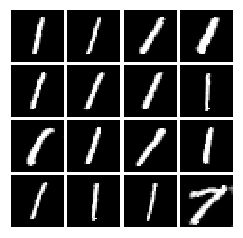


Iter: 16750, D: 0.1849, G:3.729
Iter: 16800, D: 0.2976, G:3.014
Iter: 16850, D: 0.183, G:3.635
Iter: 16900, D: 0.1768, G:3.672
Iter: 16950, D: 0.2855, G:3.193


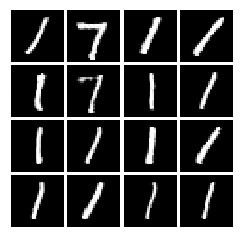


Iter: 17000, D: 0.2836, G:3.662
Iter: 17050, D: 0.1869, G:4.079
Iter: 17100, D: 0.3003, G:3.226
Iter: 17150, D: 0.249, G:2.932
Final images


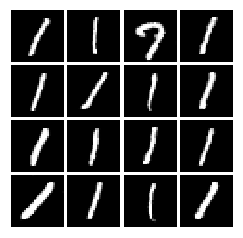

In [37]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=40)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [35]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        
        x_image = tf.reshape(x, [-1, 28, 28, 1])
        
        conv1 = tf.layers.conv2d(inputs=x_image, filters=64, kernel_size=4, strides=2, activation=leaky_relu)
        conv2 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=4, strides=2, activation=leaky_relu)
        
        bnorm = tf.layers.batch_normalization(conv2, axis=3, center=True, scale=True)
        
        N, H, W, C = bnorm.get_shape().as_list()
        flatten_layer = tf.reshape(bnorm, [-1, H*W*C])
        
        fc1 = tf.layers.dense(flatten_layer, units=1024, activation=leaky_relu)
        logits = tf.layers.dense(fc1, units=1, activation=None)
        
        return logits
    
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [36]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        full_1=tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu)
        batch_norm_1=tf.layers.batch_normalization(full_1)
        #print(batch_norm_1.get_shape())
        full_2=tf.layers.dense(inputs=batch_norm_1,units=7*7*128,activation=tf.nn.relu)
        batch_norm_2=tf.layers.batch_normalization(full_2)
        
        input_layer = tf.reshape(batch_norm_2, [-1, 7, 7, 128])
        
        [N, H, Wi, C] = input_layer.get_shape().as_list()
        
        deconv1 = tf.layers.conv2d_transpose(input_layer, filters=64, kernel_size=4, strides=2, padding="same", activation=tf.nn.relu)
        bnorm = tf.layers.batch_normalization(deconv1, axis=3)
        deconv2 = tf.layers.conv2d_transpose(bnorm, filters=1, kernel_size=4, strides=2, padding="same", activation=tf.nn.tanh)
        
        [N, H, W, C] = deconv2.get_shape().as_list()
        img=tf.reshape(deconv2,[-1,H*W*C])
        
        return img
test_generator(6595521)

Correct number of parameters in generator.


In [37]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers(learning_rate=1e-4,beta1=0.5,beta2=0.9)

In [38]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss=None
    G_loss=None
    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
    G_loss = -1.0 * tf.reduce_mean(logits_fake)
    
    # lambda from the paper
    lam = 10
    eps=0
    x_hat=0
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform(shape=[batch_size,1],minval=0.0,maxval=1.0)
    #x_hat = eps*x+(1-eps)*G_sample
    x_hat= x + eps * (G_sample-x)
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        
        grad_D_x_hat=None
        grad_D_x_hat=tf.gradients(discriminator(x_hat),[x_hat])[0]

        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat),reduction_indices=[-1]))
        
        grad_pen = lam * tf.reduce_mean((grad_norm-1.0)**2)
          
    D_loss += grad_pen 


    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

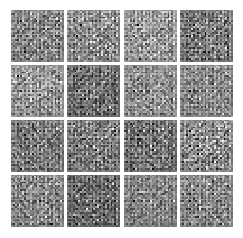


Iter: 0, D: 8.343, G:-0.001406
Iter: 50, D: -13.04, G:-5.198
Iter: 100, D: -13.33, G:-6.39
Iter: 150, D: -19.45, G:5.474
Iter: 200, D: -18.37, G:2.06


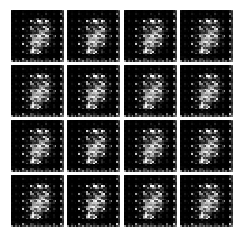


Iter: 250, D: -20.4, G:1.497


KeyboardInterrupt: 

In [39]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)